In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

# %matplotlib widget


In [3]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
from itertools import groupby
import itertools
import pickle
import glob

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# Set a professional style for the plot
plt.style.use('_mpl-gallery')
import matplotlib.dates as mdaates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
from scipy.stats import norm, kstest, skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from energy.utils_general import *
from energy.utils_energy import *
from energy.preprocessing import *
from energy.metrics import *

In [4]:
folders = ['señales_sismos', 'Iquique', 'Cobquecura', 'Navidad', 'Huasco']
folder = folders[4]

In [5]:
files_bhz = find_files(os.path.join(f"{folder}","BHZ"), ['.mseed'])

files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

In [6]:
#stations_names = [st_names.split('/')[-1] for st_names in key_names_bhz]
stations_names = [os.path.basename(st_names) for st_names in key_names_bhz]
# eliminate the G003 station
stations_names

['AC04', 'AC05', 'AC06', 'AC07', 'GO03']

In [7]:
key_names_bhz

['Huasco/BHZ/AC04',
 'Huasco/BHZ/AC05',
 'Huasco/BHZ/AC06',
 'Huasco/BHZ/AC07',
 'Huasco/BHZ/GO03']

# 1. Preprocesamiento de las trazas

La función está en preprocessing.py

In [8]:
inventory_path = "inventory"
processed_stations = {}

for station in key_names_bhz:
    processed_stations[station] = process_station(files_bhz_ch, station, inventory_path)

stations = {name: processed_stations[name] for name in key_names_bhz}

stations_BHZ = [st.select(channel = 'BHZ') for st in list(stations.values())]


In [9]:
stations_dic = {name: stations_BHZ[i][0] for i, name in enumerate(stations_names)}

# Station coordinates
stations_coord_all = {
    'HMBCX': (-20.27822, -69.88791),
    'PB12': (-18.61406, -70.32809),
    'PSGCX': (-19.59717, -70.12305),
    'AC04': (-28.204575, -71.073928),
    'AC05': (-28.836377, -70.273777),
    'AC06': (-27.357117, -70.354689),
    'AC07': (-27.1297, -70.8602),
    'BI05': (-36.74784, -73.19051),
    'BO03': (-34.49605, -71.9612),
    'CO05': (-29.91864, -71.23841),
    'CO10': (-29.24057, -71.46087),
    'ML03': (-35.717189, -72.42244),
    'TA01': (-20.5656, -70.1807),
    'TA02': (-20.2705, -70.1311),
    'VA01': (-33.022813, -71.647523),
    'GO03': (-27.5937, -70.2347),
    'GO05': (-35.0099, -71.9303)
}

In [10]:
stations_coord = {station: stations_coord_all[station] for station in stations_names}
stations_coord

{'AC04': (-28.204575, -71.073928),
 'AC05': (-28.836377, -70.273777),
 'AC06': (-27.357117, -70.354689),
 'AC07': (-27.1297, -70.8602),
 'GO03': (-27.5937, -70.2347)}

# 2. Cálculo de la energía para los eventos M>=X en la estación más cercana al evento.

## 2.1. DataFrame con eventos M>=x y M<x 
- Con calculate_detection_times se obtienen un DataFrame con todos los eventos mayores y otro con todos los menores a magnitude (parámetro que uno define)
- Usando la función nearest_n_stations de utils_energy obtengo el tiempo de inicio de los eventos M>=X y el nombre de la estación más cercana a cada evento. Cambiando st_selection, se puede elegir en vez de la primer más cercana la n-ésima más cercana a cada evento
- Luego se toman las trazas a la estación más cercana (o la n-ésima más cercana)

In [11]:
all_events = glob.glob(os.path.join(f'{folder}','*.xlsx'))[0]

df_events = pd.read_excel(all_events)

magnitude = 4.5
# P-wave propagation speed
v_P = 8.064

df_under = calculate_detection_times(df_events , stations_coord, v_P, magnitude_range = (0, magnitude-0.1))
df_over = calculate_detection_times(df_events, stations_coord, v_P, magnitude_range = (magnitude, 10))

start_times_over_, closest_sts_names_over_  = nearest_n_stations(df_over, stations_names, 4)

st_selection = 0
closest_sts_tr_over = [stations_dic[estacion] for estacion in closest_sts_names_over_[st_selection]] 
#second_closest_st_tr = [stations_dic[estacion] for estacion in closest_sts_names[1]]

start_times_over , closest_sts_names_over  = start_times_over_[st_selection], closest_sts_names_over_[st_selection] 
closest_sts_names_over 

['AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04']

## 2.2. Cálculo del inicio y fin de cada evento en la estación más cercana y sliced de la traza 
- El tiempo de inicio lo teniamos de la parte anterior
- Se calcula el término del evento como el 3% de la energía del punto máximo del evento 


In [33]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_traces = [sts.slice(start) for sts, start in zip(closest_sts_tr_over, start_times_over)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_traces = [endpoint_event(st.data)[st_selection] for st in start_traces]

pre_event = 0
post_event = end_events_traces
sample_rate = 40
sliced_traces = [traces.slice(start - pre_event, start + post_event[i]*sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr_over , start_times_over))]


## 2.3. Lo anterior sirve solo si la estación principal es la misma para todos los eventos. El código a continuación es para poder ver los eventos mayores a X en todas las estaciones
- Primero se crea un diccionario con "grouped_name_stations_over", que tiene como llave el nombre de cada estación y para cada llave tienen un número len(cantidad_eventos) el nombre de la estación (abajo ejemplo)

In [44]:
repeated_stations_over = [name for name in stations_names for _ in range(len(closest_sts_names_over))] # Una super lista con len(closest_sts_names_under) veces cada estación escrita
grouped_name_stations_over = {key: list(group) for key, group in groupby(repeated_stations_over)}
ic(grouped_name_stations_over.keys())
ic(grouped_name_stations_over['AC04'], len(grouped_name_stations_over['AC04']))

ic| grouped_name_stations_over.keys(): dict_keys(['AC04', 'AC05', 'AC06', 'AC07', 'GO03'])
ic| grouped_name_stations_over['AC04']: ['AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04']
    len(grouped_name_stations_over['AC04']): 9


(['AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04', 'AC04'], 9)

- Luego se crea un diccionario con llave el nombre de cada estación y como valor una lista que contiene el inicio de cada uno de los eventos para esa estación (ejemplo acá abajo).

In [47]:
start_times_stations_over = {name: [UTCDateTime(time) for time in df_over[f'Inicio_{name}']] for name in stations_names}
start_times_stations_over['AC04']

[2020-09-01T04:09:30.000000Z,
 2020-09-01T04:30:04.000000Z,
 2020-09-01T04:36:39.000000Z,
 2020-09-01T05:29:43.000000Z,
 2020-09-01T06:28:25.000000Z,
 2020-09-01T07:01:27.000000Z,
 2020-09-01T10:31:56.000000Z,
 2020-09-01T17:13:26.000000Z,
 2020-09-01T21:09:21.000000Z]

- Ahora bien, el siguiente diccionario es igual al anterior, pero en lugar de contener el tiempo de inicio de todos los eventos para cada estación, simplemente contiene la traza completa

In [50]:
all_sts_tr_over = {name:[stations_dic[estacion] for estacion in grouped_name_stations_over[name]] for name in stations_names} 
all_sts_tr_over['AC04']

[C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.AC04..BHZ | 2020-09-01T00:00:00.000000Z - 2020-09-02T00:00:00.000000Z | 40.0 Hz, 3456001 samples]

In [51]:
start_tr_over_all_sts = {name: [sts.slice(start) for sts, start in zip(all_sts_tr_over[name], start_times_stations_over[name])] for name in stations_names}
end_tr_over_all_sts = {name: [endpoint_event(st.data)[st_selection] for st in start_tr_over_all_sts[name]] for name in stations_names}

In [53]:
end_tr_over_all_sts

{'AC04': [2, 2, 2, 2, 2, 3, 3, 2, 5],
 'AC05': [8, 6, 6, 6, 6, 7, 7, 7, 7],
 'AC06': [5, 6, 6, 6, 5, 6, 6, 6, 7],
 'AC07': [6, 5, 5, 5, 4, 6, 5, 5, 6],
 'GO03': [6, 6, 6, 6, 5, 7, 2, 2, 7]}

In [27]:
sliced_traces

[C1.AC04..BHZ | 2020-09-01T04:09:30.000000Z - 2020-09-01T04:10:50.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T04:30:04.000000Z - 2020-09-01T04:31:24.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T04:36:39.000000Z - 2020-09-01T04:37:59.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T05:29:43.000000Z - 2020-09-01T05:31:03.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T06:28:25.000000Z - 2020-09-01T06:29:45.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T07:01:27.000000Z - 2020-09-01T07:03:27.000000Z | 40.0 Hz, 4801 samples,
 C1.AC04..BHZ | 2020-09-01T10:31:56.000000Z - 2020-09-01T10:33:56.000000Z | 40.0 Hz, 4801 samples,
 C1.AC04..BHZ | 2020-09-01T17:13:26.000000Z - 2020-09-01T17:14:46.000000Z | 40.0 Hz, 3201 samples,
 C1.AC04..BHZ | 2020-09-01T21:09:21.000000Z - 2020-09-01T21:12:41.000000Z | 40.0 Hz, 8001 samples]

In [ ]:
# plot de los eventos
fig, axs = plt.subplots(len(sliced_traces), 1, figsize=(15, 30), sharex=False)
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    start = mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)
    axs[i].plot(traces.times("matplotlib"), traces.data)
    axs[i].set_title(f'Evento {i+1}. Estación más cercana: {closest_sts_names_over[i]} \nHora de Inicio: {traces.stats.starttime + pre_event}', size=10)
    axs[i].set_ylabel('Amplitud')
    axs[i].set_xlim([axs[i].get_xlim()[0], axs[i].get_xlim()[1]])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

    # Convertir UTCDateTime a formato matplotlib
    start= mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)

    # Agregar una línea vertical roja en el tiempo de inicio del evento
    axs[i].axvline(x=start, color='r')

    # Agregar una línea vertical negra en el tiempo de finalización del evento
    axs[i].axvline(x=end, color='k')

plt.show()



In [ ]:
# plot de los eventos con su respectivo espectrograma
fig = plt.figure(figsize=(15, 75))
gs = gridspec.GridSpec(2*len(sliced_traces), 1, height_ratios=[1,2.2]*len(sliced_traces), width_ratios=[1])
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    # Plot the signal
    ax1 = plt.subplot(gs[2*i])
    ax1.plot(traces.times("matplotlib"), traces.data, color='steelblue', linewidth=1.5)
    ax1.set_title(f'Evento {i+1}. Estación más cercana: {closest_sts_names_over[i]} \nHora de Inicio: {traces.stats.starttime + pre_event} \nHora de Fin: {traces.stats.starttime + post_event[i]/sample_rate}'
                  , size=10, fontweight='bold')
    ax1.set_ylabel('Amplitud', fontsize=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora
    ax1.grid(True)

    # Plot the spectrogram
    ax2 = plt.subplot(gs[2*i+1])
    fig = traces.spectrogram(show=False, axes=ax2, title='Spectrogram', cmap=cm.jet)
    ax2.set_title('Spectrogram', size=12, fontweight='bold')
    ax2.grid(True)

plt.show()



# 3. Cálculo de la energía y potencia por frames

## 3.1. Se aplica la función de utils_energy para el cálculo de la energía y la potencia

- La energía de cada frame corresponde simplemente a la suma de todas las muestras de ese frame al cuadrado
- La potencia de cada frame corresponde basicamente a la potencia al final de cada frame. Es decir, para el primer frame el valor de la potencia sería el de la energía en ese frame divido en 4 (ya que esta es la cantidad de segundos de cada frame)

In [47]:
energy_events, power_events = zip(*[energy_power(st.data) for st in sliced_traces])

In [48]:
energy_events[0]

array([5.47667547e+06, 1.85823836e+12, 1.75327181e+15, ...,
       5.60546724e+05, 4.64686676e+05, 5.19772583e+05])

In [49]:
power_events[0]

array([1.36916887e+06, 2.32280480e+11, 1.46260838e+14, ...,
       1.63702463e+12, 1.63691094e+12, 1.63679727e+12])

In [23]:
len(power_events)

9

In [ ]:
plot_power_each(power_events, station = 'AC04', n_frames=10, use_log = True)

## 3.2. Visualizamos la energía y la potencia

### 3.2.1. La energía se visualiza para cada frame del evento en el eje x.

In [ ]:
# Plot de puntos 
# Crear una figura para los gráficos
plt.figure(figsize=(10, 20))

# Encontrar la longitud máxima en energy_events
max_len = max(len(energ) for energ in energy_events)

# Graficar la energía de cada evento
for i, energ in enumerate(energy_events, start=1):
    plt.subplot(len(energy_events), 1, i)
    plt.plot(energ, 'o-')  # Añadir marcadores a la línea
    plt.yscale('log')  # Cambiar a escala logar
    plt.title(f'Energía del evento {i}', size = 12)
    plt.xlim(0, max_len)  # Establecer la misma longitud del eje x para todos
    plt.xlabel('frames')  # Añadir leyenda al eje x
    plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [ ]:
# plot de barras
plt.figure(figsize=(10, 20))

# Encontrar la longitud máxima en energy_events
max_len = max(len(energ) for energ in energy_events)
print(max_len)

# Graficar la energía de cada evento
for i, energ in enumerate(energy_events, start=1):
    plt.subplot(len(energy_events), 1, i)
    # Cambiar a gráfico de barras con barras más delgadas
    plt.bar(np.arange(1, len(energ) + 1), energ, width=0.4)
    plt.yscale('log')  # Cambiar a escala logarítmica
    plt.title(f'Energía del evento {i} en la estación CO10', size = 12)
    plt.xlim(0, max_len + 1)  # Establecer la misma longitud del eje x para todos
    plt.xlabel('frames')  # Añadir leyenda al eje x
    plt.tight_layout()

# Mostrar los gráficos
plt.show()

### 3.2.2. Realizamos un histograma de la potencia también por frame (explicación a continuación).

- Estamos considerando entonces (como se puede observar en la función energy_power() antes definida) que la potencia correspondería a la energía del frame dividido en en (largo del frame/frecuencia de muestreo). Esta última razón nos da como resultado 4 segundos, que es el largo del frame que queremos utilizar. Por lo tanto quedaría la energía de cada frame divido por 4 segundos, lo que sería la definición de potencia.

- Entonces, a continuación, si ploteamos el histograma del primer frame, se plotea el primer frame de cada uno de los eventos. **Acá es importante considerar que no todos los eventos tienen igual duración**. En caso de utilizar un n_frames = 2, se toma para cada evento el promedio de la potencia de los frames 1 y 2 (que sería equivalente a calcular la potencia en los dos primeros frames), y así sucesivamente para el resto de los frames.

- En la función plot_power() se puede elegir entre utilizar la potencia normal, o el log de la potencia. Esto último tiene más sentido debido a que se tiene un histograma donde se pueden diferenciar las magnitudes de las potencias y podrían servir para compararlas con eventos menores que 4, o incluso trazas sin eventos.

# 4. Para realizar una comparación consideraremos dos casos:
- Trazas de estaciones con eventos catalogados pero de magnitud menor a 4.
- Trazas de estaciones sin ningún evento catalogado


## 4.1. Trazas con eventos catalogados de magnitud menor a 4

Para esto simplemente se considerarán (de la estación CO10) trazas aleatorias con la condición que no pertenezcan al catálogo general.

### 4.1.1. Creamos una lista con el tiempo de partida de cada evento para cada estación 

In [50]:
start_times_under, closest_sts_under = nearest_n_stations(df_under, stations_names, 2)
start_times_under , closest_sts_names_under = start_times_under[st_selection], closest_sts_under[st_selection] 

In [51]:
repeated_stations_under = [name for name in stations_names for _ in range(len(closest_sts_names_under))] # Una super lista con len(closest_sts_names_under) veces cada estación escrita
grouped_name_stations_under = {key: list(group) for key, group in groupby(repeated_stations_under)}
grouped_name_stations_under.keys()

dict_keys(['AC04', 'AC05', 'AC06', 'AC07', 'GO03'])

In [53]:
#start_times_PSGCX = [UTCDateTime(time) for time in df_under['Inicio_PSGCX']]
start_times_stations = {name: [UTCDateTime(time) for time in df_under[f'Inicio_{name}']] for name in stations_names}

### 4.1.4. Se guarda en una lista la traza del eje z que corresponde cada estación

In [54]:
closest_sts_tr_under = [stations_dic[estacion] for estacion in closest_sts_names_under]
all_sts_tr_under = {name:[stations_dic[estacion] for estacion in grouped_name_stations_under[name]] for name in stations_names} 

### 4.1.5. Igual que antes se calcula el término del evento como el 3% de la energía del punto máximo del evento y se toma la traza hasta ese punto

In [55]:
start_tr_under_all_sts = {name: [sts.slice(start) for sts, start in zip(all_sts_tr_under[name], start_times_stations[name])] for name in stations_names}
end_tr_under_all_sts = {name: [endpoint_event(st.data)[st_selection] for st in start_tr_under_all_sts[name]] for name in stations_names}

In [56]:
pre_event_under_four = 0
post_event_under_four = end_tr_under_all_sts
sample_rate = 40
sliced_all_traces_under = {name: [traces.slice(start - pre_event_under_four, start + post_event_under_four[name][i]*sample_rate) for i, (traces, start) in enumerate(zip(all_sts_tr_under[name], start_times_stations[name]))] for name in stations_names} 

### 4.1.6. Hacemos el cálculo de la energía y potencia de estas señales. Luego se muestra el histograma de la potencia.

In [58]:
power_all_sts_under = {}
energy_all_sts_under = {}

# Itera sobre las estaciones
for station_name, traces in sliced_all_traces_under.items():
    energy_events_under, power_events_under = zip(*[energy_power(st.data) for st in traces])
    power_all_sts_under[station_name] = power_events_under
    energy_all_sts_under[station_name] = energy_events_under

## 4.2. Trazas aleatorias tomadas de la estación principal sin eventos

### 4.2.1. Partimos elegigiendo trazas donde no existan eventos. Tomaremos de forma aleatoria 50 intervalos de 1 minuto donde no existan eventos

### Acá st lo estoy tomando como el segundo más cercano por ahora, esto después en el main debo hacerlo facilmente variable

In [61]:
# if st_selection == 0:
#     st = 'CO10'
# elif st_selection == 1:
#     st = 'AC04'

st_over = closest_sts_names_over
st_under = closest_sts_names_under


for i in range(len(stations_names)):
    no_event_intervals(df_events, stations_names[i], folder)

no_event_df = [pd.read_csv(f'{folder}/no_event_intervals_{st}.txt') for st in stations_names]

In [62]:
# El máximo intervalo varía según el dataset de eventos considerado
intervals = [len(no_event_df[i]) for i in range(len(stations_names))]
random_intervals = [no_event_df[i].sample(n=intervals[i], random_state=1) for i in range(len(stations_names))]

In [63]:
# Convertir las columnas 'Start' y 'End' a datetime
start_times_no_events = {}
end_time_no_events = {}

for i in range(len(stations_names)):

    random_intervals[i]['Start'] = pd.to_datetime(random_intervals[i]['Start'])
    random_intervals[i]['End'] = pd.to_datetime(random_intervals[i]['End'])

    # Crear las listas start_times_no_events y end_time_no_events
    start_times = random_intervals[i]['Start'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()
    end_times = random_intervals[i]['End'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()

    start_times_no_events[stations_names[i]] = [UTCDateTime(time) for time in start_times]
    end_time_no_events[stations_names[i]] = [UTCDateTime(time) for time in end_times]

    #start_times_no_events.append([UTCDateTime(time) for time in start_times])
    #end_time_no_events.append([UTCDateTime(time) for time in end_times])


### 4.2.3. Se hace el slice de las trazas para la estación que pongo ahí XD

Discutir lo siguiente: Antes, como solo tenía una estación 

In [64]:
stations_no_event = [name for name, interval_length in zip(stations_names, intervals) for _ in range(interval_length)] # Contiene los intervalos para todas las estaciones
grouped_name_stations_no_event = {key: list(group) for key, group in groupby(stations_no_event)}

all_sts_tr_no_event = {name: [stations_dic[estacion] for estacion in grouped_name_stations_no_event[name]] for name in stations_names}

sliced_traces_no_event = {name: [traces.slice(start, start + 60) for traces, start in zip(all_sts_tr_no_event[name], start_times_no_events[name])] for name in stations_names}


#sliced_traces_no_event = {name: [traces.slice(start, start + post_event_under_four[name][i]*sample_rate) for i, (traces, start) in enumerate(zip(all_sts_tr_under[name], start_times_stations[name]))] for name in stations_names} 


In [254]:
#len(sliced_traces_no_event ['PSGCX'])

In [66]:
power_events_no_event = {}
energy_events_no_events = {}
for station_name, traces in sliced_traces_no_event.items():
    energy_no_events, power_no_events = zip(*[energy_power(st.data) for st in traces])
    power_events_no_event[station_name] = power_no_events
    energy_events_no_events[station_name] = energy_no_events

### Ojo que lo siguiente plotea bien el ruido y eventos M<X para todas las estaciones, pero solo los M>X de la estación principal

In [72]:
st

'AC06'

In [ ]:
power_events_no_eventa

In [76]:
stations_names

['AC04', 'AC05', 'AC06', 'AC07', 'GO03']

#### El siguiente plot solo sirve para M>x si se usa la estación principal y esta es siempre la misma, ya que es el unico caso donde en power_events se tiene data de la misma estación.
Eso si siempre funciona en los casos M<x y de ruido, ya que antes calculo para todas las estaciones esto y de hecho está guardado en los diccionarios de esa forma. Podría intentar hacer esto ahora para M>x poder correr el histograma siempre en todos los casos

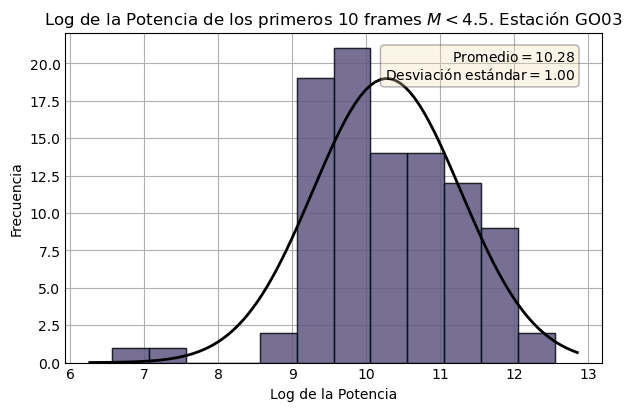

In [78]:
#type_m = 0 # M>X
type_m = 1 # M<x
#type_m = 2 # Ruido

st = stations_names[4]
power_events_all = [power_events, power_all_sts_under[st], power_events_no_event[st]]
event_type = [f'$M \geq {magnitude}$', f'$M < {magnitude}$', 'Ruido (no eventos)']
bar_colors = ['blue', 'red', 'green']
plot_power_each(power_events_all[type_m], st ,n_frames = 10, use_log = True, event_type=event_type[type_m], bar_color = bar_colors[type_m]) 

In [79]:
energy_events_all = [energy_events, energy_all_sts_under[st], energy_events_no_events[st]]
#plot_energy_hist(energy_events_all, st, frame=2, use_log=True)

## 4.3. Comparación a través del histograma de 3 casos diferentes

### Histograma de la potencia en escala log para una cantidad dada de frames

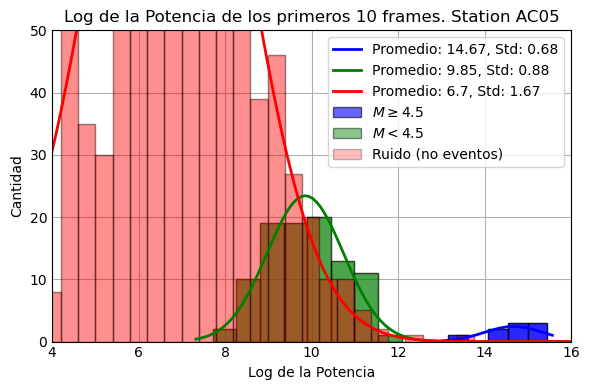

In [37]:
plot_power(power_events_all, station = st,n_frames=10, use_log=True, event_type=event_type)


### Histograma de la energía en escala log para un frame particular dado

# 5. Gráfico de curvas ROC y matriz de confusión para validación según el criterio de ENERGÍA

Como para realizar esto se necesitan tener solo dos clases, del tipo "sí" y "no", no podemos llegar y usar lo que tenemos antes directamente. Esto ya que antes consideramos 3 clases distintas. Debido a esto, se considera desde ahora dos casos de separación:
1) Sismo vs No-Sismo
2) Sismo M>4 vs No-Sismo M>4 (acá entran tanto sismos menores que 4 como cosas que no son sismos)

## 5.1. Sismo vs No-Sismo

### 5.1.1. Comenzamos definiendo las clases y asignando los labels. Consideramos un sismo como 1, y un no sismo como 0

In [231]:
classes = ['No Event', 'Event']

energy_events_flattened = [np.concatenate(events) for events in energy_events_all]
data = np.concatenate(energy_events_flattened)
# Como estamos trabajando con el log de 10 antes, lo hacemos tambien acá, hace todo más bonito jjjjjeee
log_data = np.log10(data)

labels = np.concatenate([np.ones(len(energy_events_flattened[0])),
                         np.ones(len(energy_events_flattened[1])),
                         np.zeros(len(energy_events_flattened[2]))])


### 5.1.2. Se realiza el cálculo y plot de la curva ROC y el AUC usando sklearn.

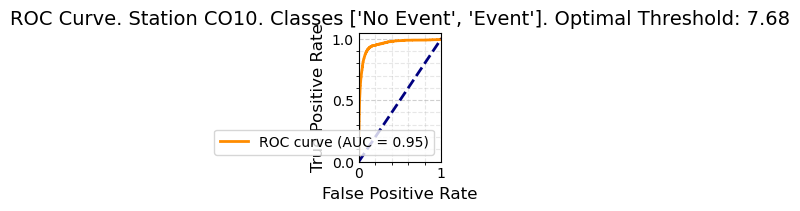

In [37]:
plot_roc_curve(labels, st ,log_data, classes)

### 5.1.3. Usado calculate_optimal_threshold de metrics.py podemos calcular el umbral óptimo según diferentes métodos

In [38]:
# LOs 3 metodos que tengo implementdo son: 'youden_index', 'euclidena_distance', 'concordance_probability'. POr defecto la función usa 'youden_index'
optimal_thr = calculate_optimal_threshold(labels, log_data)

### 5.1.4. Se plotea la matriz de confusión 

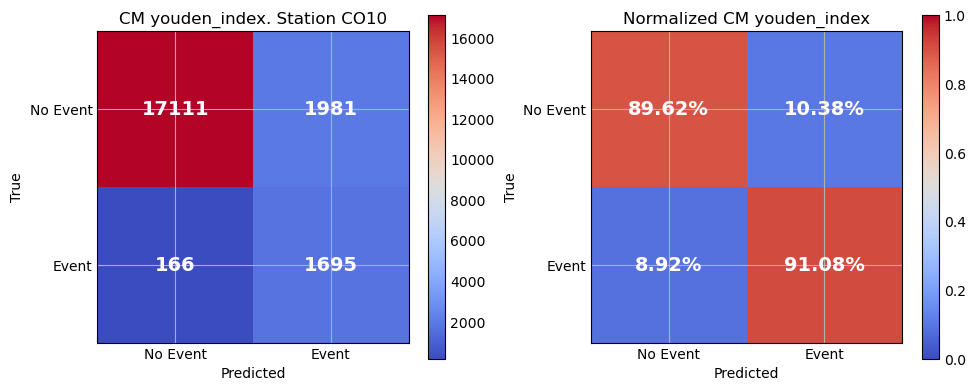

In [39]:
plot_confusion_matrix2(optimal_thr,st, 'youden_index', labels, log_data, classes)


## 5.2. Evento mayor a 4 vs No evento mayor a 4

In [40]:
classes = [f'No M>={magnitude}', f'M>={magnitude}']

#lo que cambia es la forma en que se crean los labels
labels = np.concatenate([np.ones(len(energy_events_flattened[0])),
                         np.zeros(len(energy_events_flattened[1])),
                         np.zeros(len(energy_events_flattened[2]))])


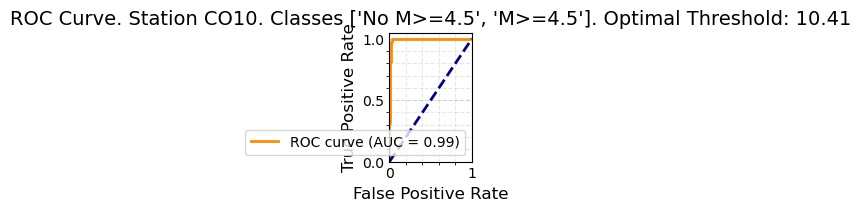

In [41]:
plot_roc_curve(labels, st ,log_data, classes)

In [42]:
optimal_thr = calculate_optimal_threshold(labels, log_data)

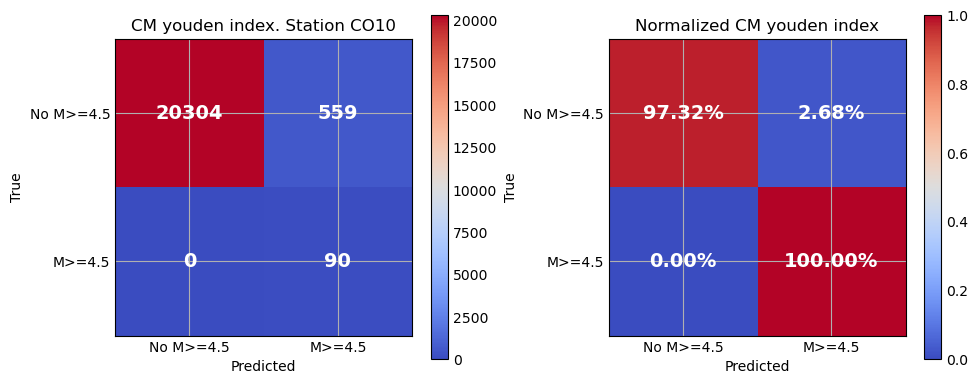

In [43]:
plot_confusion_matrix2(optimal_thr, st , 'youden index', labels, log_data, classes)

Lo anterior considera energía por la siguiente razón:
- Cada uno de los TP, FN, FP, TP que fueron calculados antes, fueron calculados para cada frame correspondiente a la clase respectiva a la que se econtrase.
- Así, si tengo un 100% de eventos bien clasificados, significa que todos los frames que de todos los eventos superan el umbral para poder ser clasificados como eventos.
- Por otro lado, el tener menos del 100% de clasificación en los TP, no implica que no detectara el evento per se, solo implica que no todos los frames del evento superan el umbral mínimo para que ese frame fuese considerado como perteneciente a un evento.

# 6. Ahora usando como criterio de separación la potencia

Se considerará la potencia hasta que se acaba el evento, no un número de frames especifico ni modificable por el momento.

## 6.1. Sismo vs No sismo

In [42]:
classes = ['No Event', 'Event']

# La siguiente linea de código toma la potencia en el último frame para cada evento (o no evento)
power_last_frame = [arr[-1] for tup in power_events_all for arr in tup]
data_power = np.array(power_last_frame)
# Como estamos trabajando con el log de 10 antes, lo hacemos tambien acá, hace todo más bonito jjjjjeee
log_data_power = np.log10(data_power)

labels_power = np.concatenate([np.ones(len(power_events_all[0])),
                         np.ones(len(power_events_all[1])),
                         np.zeros(len(power_events_all[2]))])

In [43]:
a = []
a.append(np.log10(data_power))
a

[array([15.18366261, 15.15488551, 14.28177015, ...,  7.86859622,
         6.6720155 ,  7.93465762])]

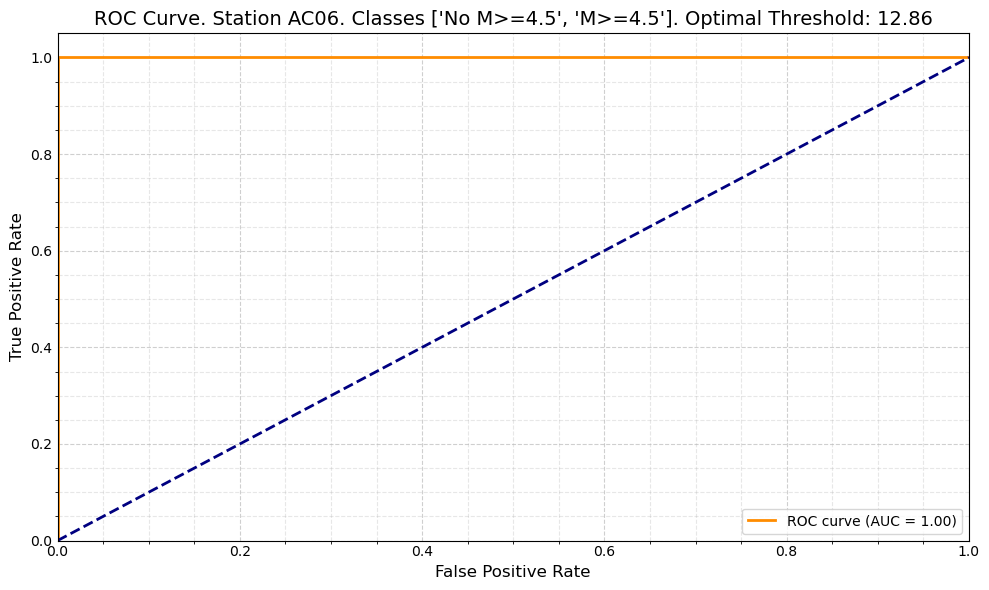

In [48]:
method = 'euclidean_distance'
plot_roc_curve(labels_power, st ,log_data_power, classes, method)


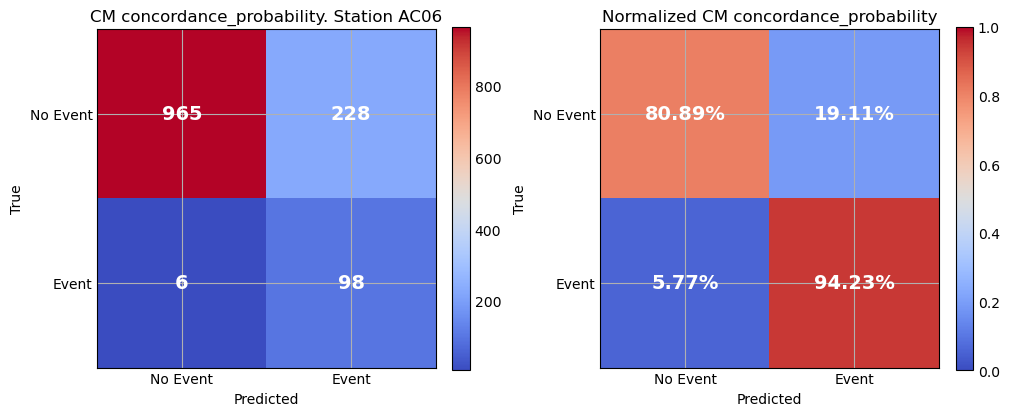

In [45]:
optimal_thr_power = calculate_optimal_threshold(labels_power, log_data_power)
plot_confusion_matrix2(optimal_thr_power, st , method, labels_power, log_data_power, classes)

## 6.2. Sismos M>=magnitude Vs Resto

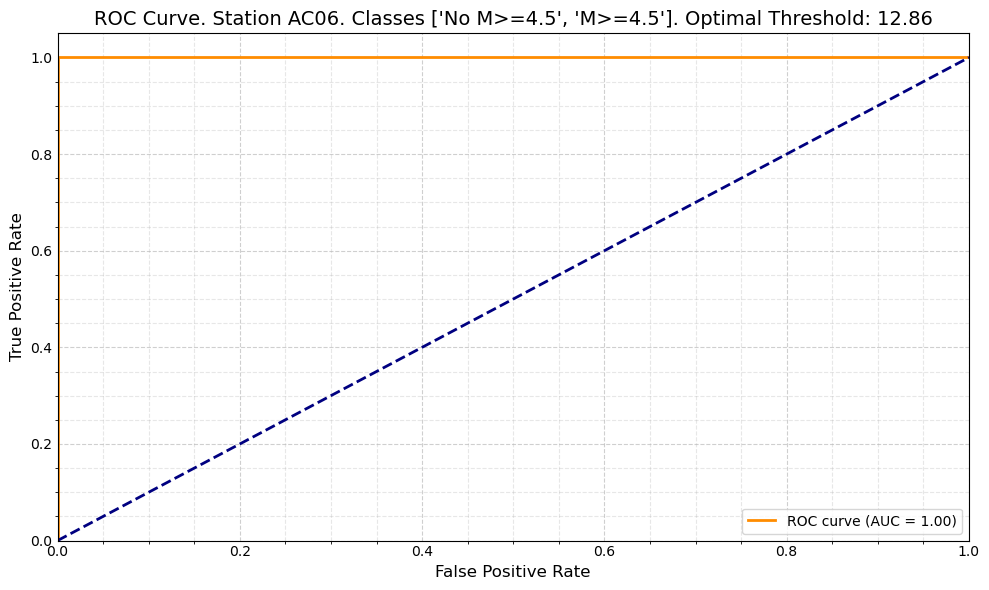

In [46]:
classes = [f'No M>={magnitude}', f'M>={magnitude}']

labels_power = np.concatenate([np.ones(len(power_events_all[0])),
                                np.zeros(len(power_events_all[1])),
                                np.zeros(len(power_events_all[2]))])
plot_roc_curve(labels = labels_power, station = st, data = log_data_power, class_type = classes, method = method)

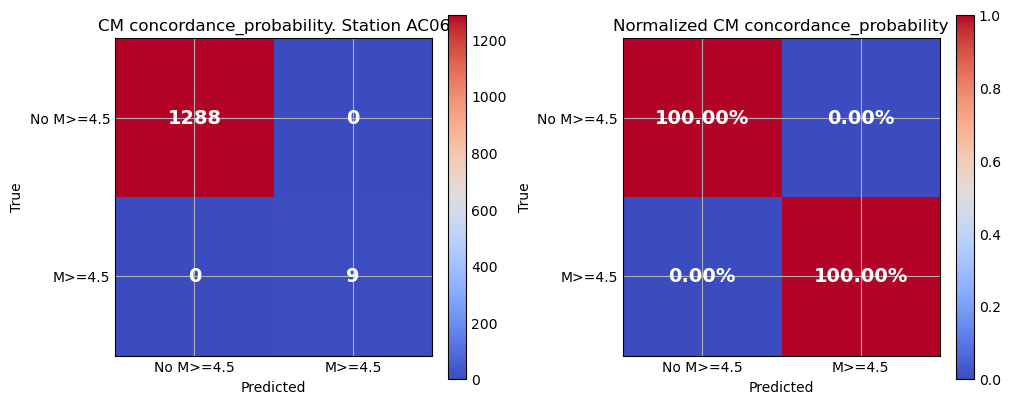

In [47]:

optimal_thr_power = calculate_optimal_threshold(labels_power, log_data_power, method=method)
plot_confusion_matrix2(optimal_thr_power, st ,method , labels_power, log_data_power, classes)

## 6.3 Encontrar la menor magnitud para la cual se separan los eventos 

In [270]:
magnitudes_a_probar = np.linspace(4.0,5.0,11)

best_magnitude, labels, data, opt_thr = find_best_magnitude(file_over = file_over, file_under = file_under, stations_coord = stations_coord ,
                                               stations_names = stations_names, stations_dic_tr = stations_dic, magnitudes = magnitudes_a_probar, method = 'youden_index', st_selection = 0)



ic| data_power: array([1.23042459e+14, 3.78341539e+13, 1.93204491e+11, ...,
                       2.11782150e+07, 4.36658101e+06, 1.95944722e+06])
ic| magnitude: 4.0
ic| f_p: 3, f_n: 0
ic| opt_thr: 11.286017216544417
ic| 'Mejoró la magnitud', best_magnitude: 4.0
ic| 'Nuevos mejores parámetros', fp: 3, fn: 0
ic| data_power: array([1.23042459e+14, 3.78341539e+13, 7.06703551e+11, ...,
                       2.11782150e+07, 4.36658101e+06, 1.95944722e+06])
ic| magnitude: 4.1
ic| f_p: 2, f_n: 0
ic| opt_thr: 11.666509913933133
ic| 'Mejoró la magnitud', best_magnitude: 4.1
ic| 'Nuevos mejores parámetros', fp: 2, fn: 0
ic| data_power: array([1.23042459e+14, 3.78341539e+13, 1.33598893e+12, ...,
                       2.11782150e+07, 4.36658101e+06, 1.95944722e+06])
ic| magnitude: 4.2
ic| f_p: 3, f_n: 0
ic| opt_thr: 11.666509913933133
ic| data_power: array([1.23042459e+14, 3.78341539e+13, 1.33598893e+12, ...,
                       2.11782150e+07, 4.36658101e+06, 1.95944722e+06])
ic| magnitude:

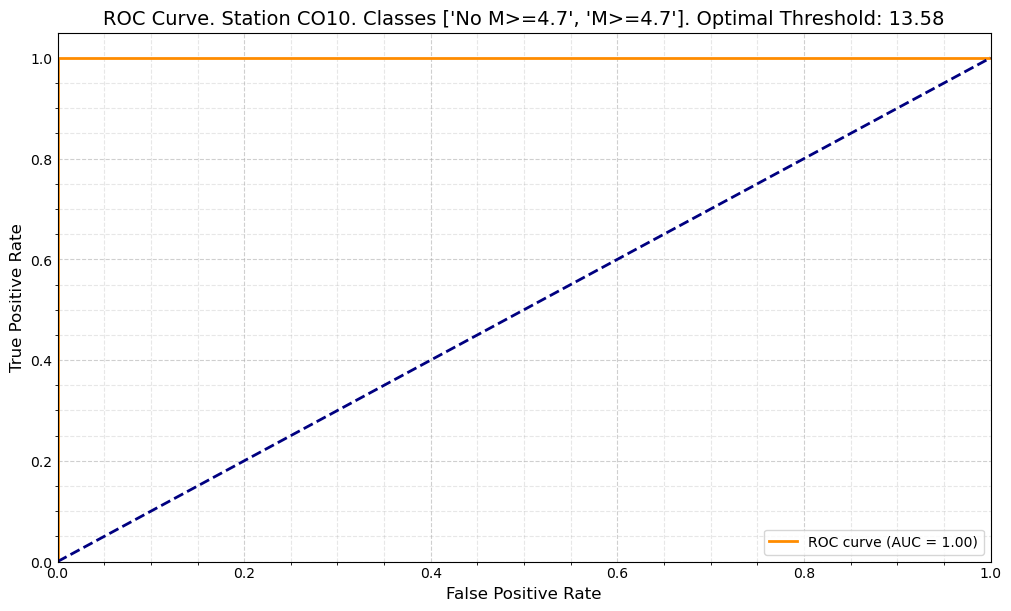

In [273]:
classes_best = [f'No M>={best_magnitude}', f'M>={best_magnitude}']

plot_roc_curve(labels, st, data, classes_best, method)

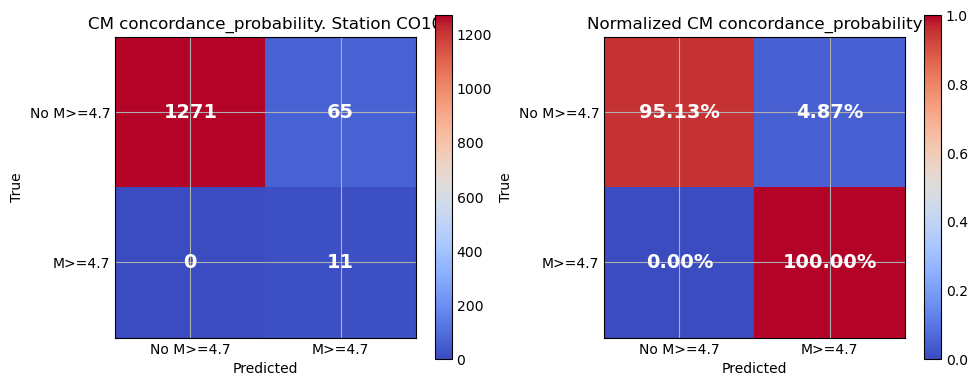

In [122]:
plot_confusion_matrix2(opt_thr, st ,method , labels, data, classes)

In [189]:
predicted_labels = np.array([1 if x >= opt_thr else 0 for x in log_data_power])

In [188]:
confusion_matrix(labels, predicted_labels)[0][1]

42

# Idea para seguir 

Cada una de las secciones que hice anteriormente recodearlas comno funciones, esto haría que todo fuese mucho más simple en términos de la facilidad de la magnitud de los eventos que quiero tomar, etc. Hacerlo despúes de almuerzo